In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from joblib import Parallel, delayed
import math

## Setup Kaggle-CLI and downlaod dataset

In [ ]:
! mkdir -p ~/.kaggle
# * Change the line below with the path to your own kaggle api key
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d weipengzhang/adobe-fivek
! unzip adobe-fivek.zip

In [ ]:
img_dir = Path('./raw')
input_imgs = list(img_dir.glob("*.jpg"))

In [ ]:
# * Resize imgs
def resize_and_central_crop(img, resize_dim):
    w, h = img.size
    w2, h2 = resize_dim
    if h > w:
        img = img.resize((w2, int(h / w * w2)))
    else:
        img = img.resize((int(w / h * h2), h2))
    # * Central crop
    w3, h3 = img.size
    left = (w3 - w2) / 2
    top = (h3 - h2) / 2
    right = (w3 + w2) / 2
    bottom = (h3 + h2) / 2
    img = img.crop((left, top, right, bottom))

    return img

def resize(img_path):
    img = Image.open(str(img_path)).convert("RGB")
    img = resize_and_central_crop(img, (512,512))
    img.save(str(img_path))

parallel = Parallel(os.cpu_count(), backend="multiprocessing")
parallel(delayed(resize)(img_path) for img_path in tqdm(input_imgs))

## Image Segmentation

### Build environment

In [ ]:
! git clone https://github.com/microsoft/unilm.git
! cd unilm/beit2 ; pip install -r requirements.txt

! pip install openmim
! mim install mmcv-full==1.3.0
! pip install scipy timm==0.3.2 mmsegmentation==0.11.0

In [ ]:
# * Download model weights
!wget https://conversationhub.blob.core.windows.net/beit-share-public/beitv2/beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth
# ckpt_path = f'"/content/drive/MyDrive/CS 7150/project/beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth"'
# ! cp $ckpt_path beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth

--2022-11-27 18:38:38--  https://conversationhub.blob.core.windows.net/beit-share-public/beitv2/beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth
Resolving conversationhub.blob.core.windows.net (conversationhub.blob.core.windows.net)... 52.191.176.36
Connecting to conversationhub.blob.core.windows.net (conversationhub.blob.core.windows.net)|52.191.176.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1963518987 (1.8G) [application/octet-stream]
Saving to: ‘beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth’

beitv2_large_patch1 100%[===================>]   1.83G  7.68MB/s    in 4m 52s  

2022-11-27 18:43:30 (6.41 MB/s) - ‘beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth’ saved [1963518987/1963518987]



### Build model

In [ ]:
sys.path.append('unilm/beit2/semantic_segmentation')
from backbone import beit
from mmseg.apis import init_segmentor, show_result_pyplot

apex is not installed
apex is not installed
apex is not installed
apex is not installed


In [ ]:
config_file = 'unilm/beit2/semantic_segmentation/configs/beit/upernet/upernet_beit_large_24_512_slide_160k_21ktoade20k.py'
checkpoint_file = 'beitv2_large_patch16_224_pt1k_ft21ktoade20k.pth'
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

Use load_from_local loader


### Model inference

In [ ]:
seg_dir = Path('./segs')
seg_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# * Copied from mmseg repo
import mmcv
import torch
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmseg.datasets.pipelines import Compose

class LoadImage:
    """A simple pipeline to load image."""

    def __call__(self, results):
        """Call function to load images into results.

        Args:
            results (dict): A result dict contains the file name
                of the image to be read.

        Returns:
            dict: ``results`` will be returned containing loaded image.
        """

        if isinstance(results['img'], str):
            results['filename'] = results['img']
            results['ori_filename'] = results['img']
        else:
            results['filename'] = None
            results['ori_filename'] = None
        img = mmcv.imread(results['img'])
        results['img'] = img
        results['img_shape'] = img.shape
        results['ori_shape'] = img.shape
        return results

def inference_segmentor(model, imgs):
    """Inference image(s) with the segmentor.

    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.

    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    test_pipeline = [LoadImage()] + cfg.data.test.pipeline[1:]
    test_pipeline = Compose(test_pipeline)
    # prepare data
    data = []
    imgs = imgs if isinstance(imgs, list) else [imgs]
    for img in imgs:
        img_data = dict(img=img)
        img_data = test_pipeline(img_data)
        data.append(img_data)
    data = collate(data, samples_per_gpu=len(imgs))
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data['img_metas'] = [i.data[0] for i in data['img_metas']]

    # forward the model
    with torch.no_grad():
        result = model(return_loss=False, rescale=True, **data)
    return result

In [ ]:
batch_size = 8
for i in tqdm(range(math.ceil(len(input_imgs)/batch_size))):
    paths = input_imgs[i*batch_size:(i+1)*batch_size]
    res = inference_segmentor(model, [str(p) for p in paths])
    for j in range(len(paths)):
        img = paths[j]
        np.save(str(seg_dir / (img.stem+".npy")), res[j].astype('uint8'))

100%|██████████| 625/625 [58:26<00:00,  5.61s/it]


In [ ]:
! mkdir seg_dataset
! mv segs.zip seg_dataset/segs.zip

In [ ]:
# ! kaggle datasets metadata -p seg_dataset weipengzhang/beit2-adobe5k
# ! kaggle datasets version -p ./seg_dataset -m "Updated data"

Downloaded metadata to seg_dataset/dataset-metadata.json


In [ ]:
from mmseg.apis import show_result_pyplot

In [ ]:
img = Image.open(str(paths[-1]))

/usr/local/lib/python3.7/dist-packages/mmseg/models/segmentors/base.py:267: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


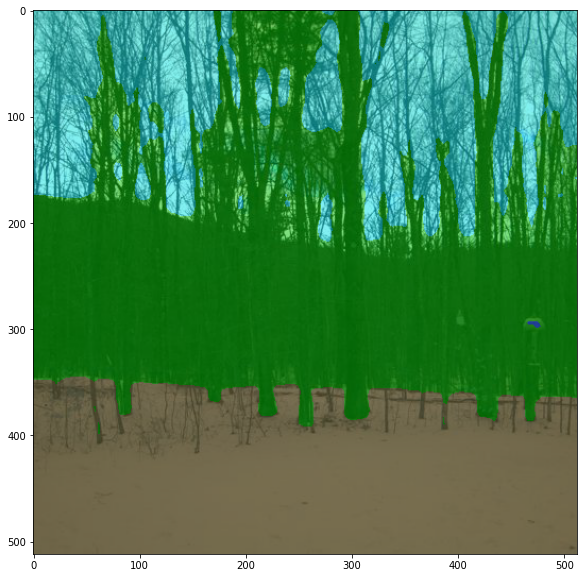

In [ ]:
show_result_pyplot(model, np.array(img), [res[-1]])